In [68]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Path to the folder containing the .csv files
folder_path = 'data/csv-clean-renamed'  # Adjust the path to the directory

# Read the data
wavenumbers = []
data = []
labels = []

for filename in os.listdir(folder_path):
    if filename.endswith('.csv'):
        filepath = os.path.join(folder_path, filename)
        spectrum = pd.read_csv(filepath, delimiter=',', header=None)
        wavenumbers.append(spectrum[0].values)  # Assuming first column is wavelength
        data.append(spectrum[1].values)  # Assuming second column is intensity
        # Extract concentration from filename
        concentration = float(filename.split('_')[0].replace('conc-', ''))
        labels.append(concentration)

wavenumbers = np.array(wavenumbers)
data = np.array(data)
labels = np.array(labels)

max_wavenumber = 1800
index_max_1500 = np.where(wavenumbers[0] <= max_wavenumber)[0][-1]
data_trimmed = data[:, :index_max_1500 + 1]
data_normalized = np.array([spectrum / np.sum(spectrum) for spectrum in data_trimmed])

# Standard scaling
scaler = StandardScaler()
data_normalized = scaler.fit_transform(data_normalized)

X = data_normalized
y = labels

# Define PyTorch dataset and dataloader
class SpectraDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).view(-1, 1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Define the neural network model
class Net(nn.Module):
    def __init__(self, input_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# Training function
def train_model(model, criterion, optimizer, dataloader, num_epochs=200):
    model.train()
    for epoch in range(num_epochs):
        for inputs, labels in dataloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

# Evaluation function
def evaluate_model(model, dataloader):
    model.eval()
    predictions, true_labels = [], []
    with torch.no_grad():
        for inputs, labels in dataloader:
            outputs = model(inputs)
            predictions.append(outputs.numpy())
            true_labels.append(labels.numpy())
    return np.vstack(predictions), np.vstack(true_labels)

# Cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
mse_scores, mae_scores, r2_scores = [], [], []

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    train_dataset = SpectraDataset(X_train, y_train)
    test_dataset = SpectraDataset(X_test, y_test)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

    model = Net(input_size=X_train.shape[1])
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_model(model, criterion, optimizer, train_loader, num_epochs=250)
    predictions, true_labels = evaluate_model(model, test_loader)

    mse = mean_squared_error(true_labels, predictions)
    mae = mean_absolute_error(true_labels, predictions)
    r2 = r2_score(true_labels, predictions)

    mse_scores.append(mse)
    mae_scores.append(mae)
    r2_scores.append(r2)

print(f"Cross-Validated MSE: {np.mean(mse_scores)} ± {np.std(mse_scores)}")
print(f"Cross-Validated MAE: {np.mean(mae_scores)} ± {np.std(mae_scores)}")
print(f"Cross-Validated R^2: {np.mean(r2_scores)} ± {np.std(r2_scores)}")

# Feature importance
weights = model.fc1.weight.data.numpy()
feature_importance = np.sum(np.abs(weights), axis=0)
indices = np.argsort(feature_importance)[::-1]

# print("Feature ranking:")
# for i in range(len(feature_importance)):
#     print(f"Feature {indices[i]} (Wavenumber {wavenumbers[0][indices[i]]}): {feature_importance[indices[i]]}")

from sklearn.metrics import mean_squared_error, mean_absolute_error

# Final evaluation on a separate test set
model.eval()
predictions = model(torch.tensor(X_test, dtype=torch.float32)).detach().numpy()
r2 = r2_score(y_test, predictions)
print(f"R^2 on test set: {r2}")

# Dictionary containing true values for the unknown samples
true_values = {
    'test-file-20.dpt': 20.0  # Replace with actual values
}

# Prediction for an unknown sample
def predict_concentration_for_unknown_samples(unknown_sample_filename):
    print(f'File name: {unknown_sample_filename}')
    unknown_sample_filepath = os.path.join('C:\\Users\\baubl\\OneDrive\\Stalinis kompiuteris\\Nuova cartella\\test', unknown_sample_filename)
    unknown_spectrum = pd.read_csv(unknown_sample_filepath, delimiter=',', header=None)
    index_max_1800 = np.where(unknown_spectrum[0] <= max_wavenumber)[0][-1]
    data_trimmed_unknown = unknown_spectrum[1].values[:index_max_1800 + 1]
    normalized_unknown_spectrum = data_trimmed_unknown / np.sum(data_trimmed_unknown)
    normalized_unknown_spectrum = scaler.transform([normalized_unknown_spectrum])  # Apply same scaling
    normalized_unknown_spectrum = torch.tensor(normalized_unknown_spectrum, dtype=torch.float32)

    predicted_percentage = model(normalized_unknown_spectrum).item()
    print(f'Predicted Percentage For Green Pigment: {predicted_percentage}')
    
    # Calculate MSE and MAE for the prediction
    true_value = true_values[unknown_sample_filename]
    mse_value = mean_squared_error([true_value], [predicted_percentage])
    mae_value = mean_absolute_error([true_value], [predicted_percentage])
    print(f'MSE for {unknown_sample_filename}: {mse_value}')
    print(f'MAE for {unknown_sample_filename}: {mae_value}')

# Predict and print MSE and MAE values for each file
predict_concentration_for_unknown_samples('test-file-20.dpt')


# Feature importance
weights = model.fc1.weight.data.numpy()
feature_importance = np.sum(np.abs(weights), axis=0)
indices = np.argsort(feature_importance)[::-1]







 


Cross-Validated MSE: 90.1611557006836 ± 63.94324493408203
Cross-Validated MAE: 7.116081237792969 ± 2.6303822994232178
Cross-Validated R^2: 0.9053360104560852 ± 0.06794026113236548
R^2 on test set: 0.9460011034611175
File name: test-file-66.dpt
Predicted Percentage: 68.0896987915039
MSE for test-file-66.dpt: 2.219202489408216
MAE for test-file-66.dpt: 1.489698791503912


Cross-Validated MSE: 99.14689636230469 ± 54.7070198059082
Cross-Validated MAE: 7.1732940673828125 ± 2.3170058727264404
Cross-Validated R^2: 0.8914727449417115 ± 0.05938945645419557
Detected Peaks: []


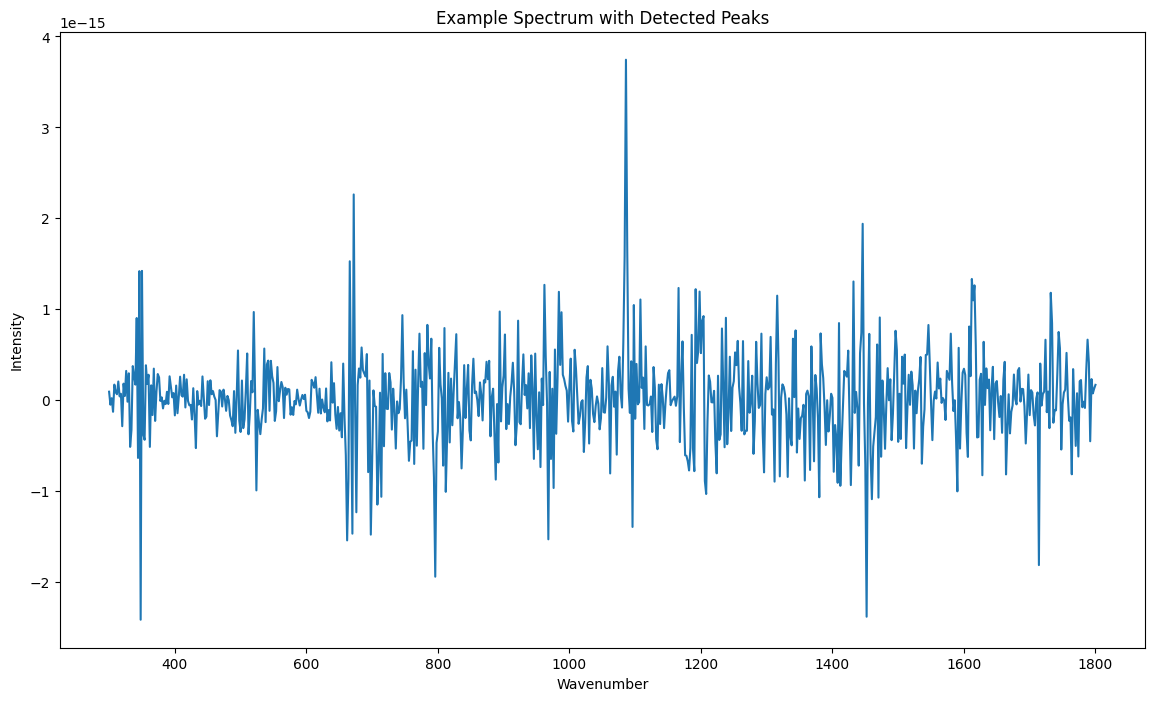

No peaks detected or processed.
R^2 on test set: 0.8286276813231861
File name: test-file-20.dpt
Predicted Percentage: 22.586593627929688
MSE for test-file-20.dpt: 6.690466596046463
MAE for test-file-20.dpt: 2.5865936279296875
File name: test-file-66.dpt
Predicted Percentage: 60.244773864746094
MSE for test-file-66.dpt: 40.38889923021423
MAE for test-file-66.dpt: 6.355226135253901
File name: test-file-33.dpt
Predicted Percentage: 34.039710998535156
MSE for test-file-33.dpt: 0.5471723613538821
MAE for test-file-33.dpt: 0.7397109985351591
File name: test-file-50.dpt
Predicted Percentage: 48.113807678222656
MSE for test-file-50.dpt: 3.5577214747318067
MAE for test-file-50.dpt: 1.8861923217773438
File name: test-file-51.dpt
Predicted Percentage: 47.61683654785156
MSE for test-file-51.dpt: 5.679468039656058
MAE for test-file-51.dpt: 2.3831634521484375


In [64]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# Path to the folder containing the .csv files
folder_path = 'data/csv-clean-renamed'  # Adjust the path to the directory

# Read the data
wavenumbers = []
data = []
labels = []

for filename in os.listdir(folder_path):
    if filename.endswith('.csv'):
        filepath = os.path.join(folder_path, filename)
        spectrum = pd.read_csv(filepath, delimiter=',', header=None)
        wavenumbers.append(spectrum[0].values)  # Assuming first column is wavelength
        data.append(spectrum[1].values)  # Assuming second column is intensity
        # Extract concentration from filename
        concentration = float(filename.split('_')[0].replace('conc-', ''))
        labels.append(concentration)

wavenumbers = np.array(wavenumbers)
data = np.array(data)
labels = np.array(labels)

max_wavenumber = 1800
index_max_1500 = np.where(wavenumbers[0] <= max_wavenumber)[0][-1]
wavenumbers_trimmed = wavenumbers[0][:index_max_1500 + 1]
data_trimmed = data[:, :index_max_1500 + 1]
data_normalized = np.array([spectrum / np.sum(spectrum) for spectrum in data_trimmed])

# Standard scaling
scaler = StandardScaler()
data_normalized = scaler.fit_transform(data_normalized)

X = data_normalized
y = labels

# Define PyTorch dataset and dataloader
class SpectraDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).view(-1, 1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Define the neural network model
class Net(nn.Module):
    def __init__(self, input_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# Training function
def train_model(model, criterion, optimizer, dataloader, num_epochs=200):
    model.train()
    for epoch in range(num_epochs):
        for inputs, labels in dataloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

# Evaluation function
def evaluate_model(model, dataloader):
    model.eval()
    predictions, true_labels = [], []
    with torch.no_grad():
        for inputs, labels in dataloader:
            outputs = model(inputs)
            predictions.append(outputs.numpy())
            true_labels.append(labels.numpy())
    return np.vstack(predictions), np.vstack(true_labels)

# Cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
mse_scores, mae_scores, r2_scores = [], [], []

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    train_dataset = SpectraDataset(X_train, y_train)
    test_dataset = SpectraDataset(X_test, y_test)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

    model = Net(input_size=X_train.shape[1])
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_model(model, criterion, optimizer, train_loader, num_epochs=250)
    predictions, true_labels = evaluate_model(model, test_loader)

    mse = mean_squared_error(true_labels, predictions)
    mae = mean_absolute_error(true_labels, predictions)
    r2 = r2_score(true_labels, predictions)

    mse_scores.append(mse)
    mae_scores.append(mae)
    r2_scores.append(r2)

print(f"Cross-Validated MSE: {np.mean(mse_scores)} ± {np.std(mse_scores)}")
print(f"Cross-Validated MAE: {np.mean(mae_scores)} ± {np.std(mae_scores)}")
print(f"Cross-Validated R^2: {np.mean(r2_scores)} ± {np.std(r2_scores)}")

# Feature importance
weights = model.fc1.weight.data.numpy()
feature_importance = np.sum(np.abs(weights), axis=0)
indices = np.argsort(feature_importance)[::-1]


# Identify Peaks with adjusted parameters
peaks, properties = find_peaks(example_spectrum, height=0.05, distance=20)  # Adjust height and distance parameters as needed

print(f"Detected Peaks: {peaks}")

# Plot the example spectrum with detected peaks
plt.figure(figsize=(14, 8))
plt.plot(wavenumbers_trimmed, example_spectrum)
plt.plot(wavenumbers_trimmed[peaks], example_spectrum[peaks], "x")
plt.xlabel('Wavenumber')
plt.ylabel('Intensity')
plt.title('Example Spectrum with Detected Peaks')
plt.show()

# Compute Feature Importance for Peaks
peak_importances = []

for peak in peaks:
    # Define a range around the peak (you may need to adjust the range width)
    peak_range = range(max(0, peak-2), min(len(feature_importance), peak+3))
    
    # Compute the importance for the peak as the sum of importances within the peak range
    peak_importance = np.sum(feature_importance[list(peak_range)])
    peak_importances.append((wavenumbers_trimmed[peak], peak_importance))

# Sort peaks by their importance
peak_importances.sort(key=lambda x: x[1], reverse=True)

# Extract wavenumbers and importances for plotting
if peak_importances:
    peak_wavenumbers, peak_importance_values = zip(*peak_importances)

    # Plot the peak importances
    plt.figure(figsize=(14, 8))
    plt.bar(range(len(peak_wavenumbers)), peak_importance_values, align='center')
    plt.xticks(range(len(peak_wavenumbers)), peak_wavenumbers, rotation=90)
    plt.xlabel('Wavenumber (Peak)')
    plt.ylabel('Peak Importance')
    plt.title('Peak Importances')
    plt.tight_layout()
    plt.show()
else:
    print("No peaks detected or processed.")

# Final evaluation on a separate test set
model.eval()
predictions = model(torch.tensor(X_test, dtype=torch.float32)).detach().numpy()
r2 = r2_score(y_test, predictions)
print(f"R^2 on test set: {r2}")

# Dictionary containing true values for the unknown samples
true_values = {
    'test-file-20.dpt': 20.0,  # Replace with actual values
    'test-file-66.dpt': 66.6,
    'test-file-33.dpt': 33.3,
    'test-file-50.dpt': 50.0,
    'test-file-51.dpt': 50.0
}

# Prediction for an unknown sample
def predict_concentration_for_unknown_samples(unknown_sample_filename):
    print(f'File name: {unknown_sample_filename}')
    unknown_sample_filepath = os.path.join('C:\\Users\\baubl\\OneDrive\\Stalinis kompiuteris\\Nuova cartella\\test', unknown_sample_filename)
    unknown_spectrum = pd.read_csv(unknown_sample_filepath, delimiter=',', header=None)
    index_max_1800 = np.where(unknown_spectrum[0] <= max_wavenumber)[0][-1]
    data_trimmed_unknown = unknown_spectrum[1].values[:index_max_1800 + 1]
    normalized_unknown_spectrum = data_trimmed_unknown / np.sum(data_trimmed_unknown)
    normalized_unknown_spectrum = scaler.transform([normalized_unknown_spectrum])  # Apply same scaling
    normalized_unknown_spectrum = torch.tensor(normalized_unknown_spectrum, dtype=torch.float32)

    predicted_percentage = model(normalized_unknown_spectrum).item()
    print(f'Predicted Percentage: {predicted_percentage}')
    
    # Calculate MSE and MAE for the prediction
    true_value = true_values[unknown_sample_filename]
    mse_value = mean_squared_error([true_value], [predicted_percentage])
    mae_value = mean_absolute_error([true_value], [predicted_percentage])
    print(f'MSE for {unknown_sample_filename}: {mse_value}')
    print(f'MAE for {unknown_sample_filename}: {mae_value}')

# Predict and print MSE and MAE values for each file
predict_concentration_for_unknown_samples('test-file-20.dpt')
predict_concentration_for_unknown_samples('test-file-66.dpt')
predict_concentration_for_unknown_samples('test-file-33.dpt')
predict_concentration_for_unknown_samples('test-file-50.dpt')
predict_concentration_for_unknown_samples('test-file-51.dpt')
